In [1]:
import open3d as o3d
from PyQt5.QtWidgets import QFileDialog, QWidget, QApplication
QApp = QApplication([])
QWidget = QWidget()
import os
import pickle
import numpy as np

from scipy.spatial.transform import Rotation as R

import matplotlib.pyplot as plt


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


QSettings::value: Empty key passed
QSettings::value: Empty key passed


Load map

In [9]:
# Load ply map into open3d
world_file = QFileDialog.getOpenFileName(QWidget, 'Open file', "/home/daniel/Documents/master/maps/island_boy2.ply")[0]
if not os.path.isfile(world_file):
    raise FileNotFoundError("World file not found.")
world = o3d.io.read_triangle_mesh(world_file)
print("World loaded from file: ", world_file)
print("World has normals: ", world.has_triangle_normals(), "\nWorld has vertex normals: ", world.has_vertex_normals())
# Check if world triangles has normals
if not world.has_triangle_normals():
    print("Computing normals")
    # Compute normals
    world.compute_triangle_normals()
else:
    print("World has normals")

# Visualize world
o3d.visualization.draw_geometries([world])

World loaded from file:  /home/daniel/Documents/master/maps/island_boy2.ply
World has normals:  False 
World has vertex normals:  True
Computing normals


In [5]:
def get_localization_data(file_path):

	with open(file_path, "rb") as f:
		data = pickle.load(f)

	print(len(data))

	orientations = []
	positions = []
	timesteps = []
	for msg in data:
		positions.append(msg[0])
		orientations.append(msg[1])
		timesteps.append(msg[2])


	localization_dict = {"orientations" : orientations, "positions" : positions, "timesteps" : timesteps}
	return localization_dict

def get_odom_data(dict, dict_key):
	orientations = []
	positions = []
	velocities = []
	ang_velocities = []
	timesteps = []
	for msg in dict[dict_key]:
		orientations.append(R.from_quat([msg.pose.pose.orientation.x, msg.pose.pose.orientation.y, msg.pose.pose.orientation.z, msg.pose.pose.orientation.w]))
		positions.append(np.array([msg.pose.pose.position.x, msg.pose.pose.position.y, msg.pose.pose.position.z]))
		velocities.append(np.array([msg.twist.twist.linear.x, msg.twist.twist.linear.y, msg.twist.twist.linear.z]))
		ang_velocities.append(np.array([msg.twist.twist.angular.x, msg.twist.twist.angular.y, msg.twist.twist.angular.z]))
		timesteps.append(msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9)

	odom_dict = {"orientations" : orientations, "positions" : positions, "velocities" : velocities, "ang_velocities" : ang_velocities, "timesteps" : timesteps}
	return odom_dict

# from rosbags.rosbag2 import Reader
# from rosbags.serde import deserialize_cdr
# # Load all messages on topic /wagon/base_link_pose_gt

# def load_from_bag(bag_file, topic):
#     gt_positions = []
#     gt_orientations = []
#     clock = []
#     with Reader(bag_file) as reader:
#         #for connection in reader.connections:
#             #print(connection.topic, connection.msgtype)
#         for connection, timestamp, rawdata in reader.messages():
#             if connection.topic == topic:
#                 msg = deserialize_cdr(rawdata, connection.msgtype)
#                 #print(msg.header.frame_id)
#                 #print(msg.pose.pose.position.x)
#                 gt_positions.append([msg.pose.pose.position.x, msg.pose.pose.position.y, msg.pose.pose.position.z])
#                 gt_orientations.append([msg.pose.pose.orientation.x, msg.pose.pose.orientation.y, msg.pose.pose.orientation.z, msg.pose.pose.orientation.w])
#                 clock.append(msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9)

#     return gt_positions, gt_orientations, clock
# Create lineset from positions
# Create lineset [[0,1], [1,2], [2,3], ...]
def create_lineset(positions, color):
    lines = []
    for i in range(len(positions)-1):
        lines.append([i, i+1])
    lineset = o3d.geometry.LineSet()
    lineset.points = o3d.utility.Vector3dVector(positions)
    lineset.lines = o3d.utility.Vector2iVector(lines)
    lineset.colors = o3d.utility.Vector3dVector([color for i in range(len(lines))])
    return lineset

In [11]:
file_path = QFileDialog.getOpenFileName(QWidget, 'Open file', "/home/daniel/master/odom_test")[0]
with open(file_path, "rb") as f:
    data = pickle.load(f)
    
base_gt = get_odom_data(data, "base_link_pose_gt")

base_ekf_full = get_odom_data(data, "odometry_ekf")


file_path = QFileDialog.getOpenFileName(QWidget, 'Open file', "/home/daniel/master/odom_test")[0]
with open(file_path, "rb") as f:
    data = pickle.load(f)
   
base_ekf_single_imu = get_odom_data(data, "odometry_ekf")


file_path = QFileDialog.getOpenFileName(QWidget, 'Open file', "/home/daniel/master/odom_test")[0]
with open(file_path, "rb") as f:
    data = pickle.load(f)
   
base_ekf_odom = get_odom_data(data, "odometry_ekf")


Qt: Session management error: networkIdsList argument is NULL


Bag file:  /home/junge/Documents/bags/island_boy_to_rule_them_all
Bag file:  /home/junge/Documents/bags/montecarlo_dataset/mesh_world


In [14]:
gt_lineset = create_lineset(base_gt["positions"], [1,0,0])
ekf_full = create_lineset(base_ekf_full["positions"], [0,1,0])
ekf_single = create_lineset(base_ekf_single_imu["positions"], [0,0,1])
ekf_odom = create_lineset(base_ekf_odom["positions"], [0,1,1])
#mapping_lineset = create_lineset(mapping_positions, [0,0,1])
# mapping_file = QFileDialog.getOpenFileName(QWidget, 'Open pkl file of mapping data', "/home/daniel/Documents/bags/island_boy_2_gt.pkl")[0]
# print("Mapping file: ", mapping_file)
# # Load mapping data pickle
# with open(mapping_file, "rb") as f:
#     mapping_list = pickle.load(f)
# mapping_lineset = create_lineset(mapping_list, [0,0,1])
# Visualize
o3d.visualization.draw_geometries([world, gt_lineset, ekf_full, ekf_single, ekf_odom])



In [16]:

dist = []
angular_difference = []

gt_positions = np.array(base_gt["positions"])
# loc_positions = np.array(localization_dict["positions"])

for i, pos in enumerate(base_ekf_full["positions"]):
    idx = np.argmin(np.linalg.norm(gt_positions - pos, axis=1))
    dist.append(np.linalg.norm(gt_positions[idx] - pos))
    # Calculate difference in roll, pitch and yaw between gt and localization
    print(base_gt["positions"][idx], base_ekf_full["positions"][i])
    gt_rpy = R.from_quat(base_gt["orientations"][idx]).as_euler('xyz', degrees=False)
    loc_rpy = R.from_quat(base_ekf_full["orientations"][i]).as_euler('xyz', degrees=False)
    # Get as three separate angles, respecting circularity
    roll_diff = np.arctan2(np.sin(gt_rpy[0] - loc_rpy[0]), np.cos(gt_rpy[0] - loc_rpy[0]))
    pitch_diff = np.arctan2(np.sin(gt_rpy[1] - loc_rpy[1]), np.cos(gt_rpy[1] - loc_rpy[1]))
    yaw_diff = np.arctan2(np.sin(gt_rpy[2] - loc_rpy[2]), np.cos(gt_rpy[2] - loc_rpy[2]))
    angular_difference.append([roll_diff, pitch_diff, yaw_diff])

angular_difference = np.array(angular_difference)

fig, ax = plt.subplots(2,1)

# Plot distance vs time
ax[0].plot(base_ekf_full["timesteps"], dist)
ax[0].set_ylabel("Distance [m]")

# Set width and height of plot
width = 8
height = 4
fig.set_figwidth(width)
fig.set_figheight(height)

# Plot angular difference vs time
ax[1].plot(base_ekf_full["timesteps"], angular_difference[:,0], label="roll")
ax[1].plot(base_ekf_full["timesteps"], angular_difference[:,1], label="pitch")
ax[1].plot(base_ekf_full["timesteps"], angular_difference[:,2], label="yaw")

# Vertically align y labels on plot 0 and 1
fig.align_ylabels()

# Place legend horizontally
ax[1].legend(loc='lower right', ncol=3, fancybox=True, shadow=True)

ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Angular difference [rad]")

plt.show()


gt_rpy = R.from_quat(base_gt["orientations"]).as_euler('xyz', degrees=False)
# Plot gt roll, pitch and yaw in a single plot
plt.plot(base_gt["timesteps"], gt_rpy[:,0], label="roll")
plt.plot(base_gt["timesteps"], gt_rpy[:,1], label="pitch")
plt.plot(base_gt["timesteps"], gt_rpy[:,2], label="yaw")
plt.legend(loc='lower right', ncol=3, fancybox=True, shadow=True)
plt.xlabel("Time [s]")
plt.ylabel("Angular difference [rad]")
plt.gcf().set_figwidth(width)
plt.gcf().set_figheight(height)
plt.show()

[-2.26497650e-04 -2.85275560e-03 -4.08877373e-06] [ 4.49897062e-10 -8.04726732e-09  5.00000002e-01]


ValueError: setting an array element with a sequence.

0th index is x rays, 0th element is y particles


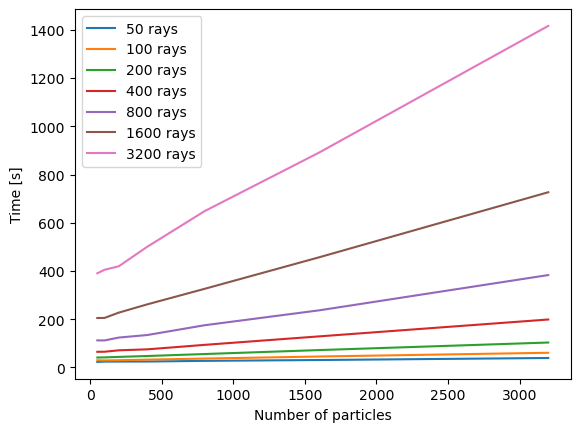

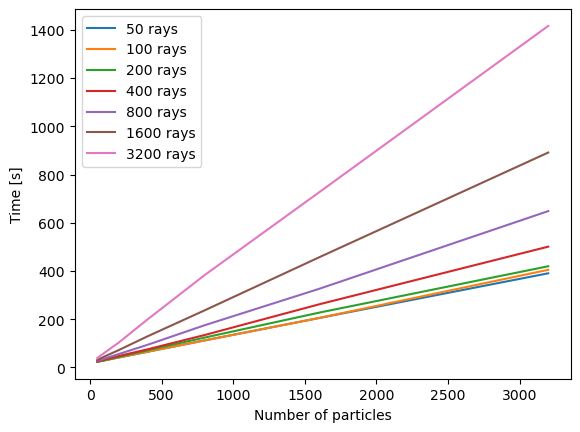

In [29]:
# Load times from test_data/times.txt
times = np.zeros((8,8))
times[0, :] = [np.nan, 50, 100, 200, 400, 800, 1600, 3200]
times[1:, 0] = [50, 100, 200, 400, 800, 1600, 3200]
with open("/home/junge/master_ws/src/Danitech-master/lmao/lmao/test_data/times.txt", "r") as f:
    # "Time for x rays and y particles: z"
    for line in f:
        line = line.split()
        x = int(line[2])
        x = times[:,0].tolist().index(x)
        y = int(line[5])
        y = times[0,:].tolist().index(y)
        times[x,y] = float(line[7])
    print("0th index is x rays, 0th element is y particles")
times = np.array(times)

# Plot times as a line
plt.plot(times[0, 1:], times[1:, 1:])
plt.xlabel("Number of particles")
plt.ylabel("Time [s]")
plt.legend(["50 rays", "100 rays", "200 rays", "400 rays", "800 rays", "1600 rays", "3200 rays"])
# set y log scale
plt.show()

